In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb

plt.style.use('seaborn-whitegrid')
import warnings
warnings.filterwarnings('ignore')



In [2]:
train_data = pd.read_csv('data/train.csv',parse_dates=['date'],index_col='date')
test_data = pd.read_csv('data/test.csv',parse_dates=['date'],index_col='date')
train_data.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [4]:
# select where store==1 and item ==1
tmp = train_data[(train_data.store==1) & (train_data.item==1)]
tmp.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


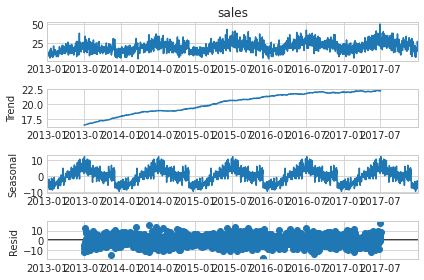

In [4]:
# seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(tmp.sales, model='additive', period=365)
decompose.plot()
plt.show()

In [5]:
# select where year <2017
train = tmp[tmp.index.year<2017]
test = tmp[tmp.index.year==2017]


In [6]:
# adf test for stationarity
from statsmodels.tsa.stattools import adfuller
adf = adfuller(train.sales,regression='ct')
p_value = adf[1]
if p_value < 0.05:
    print('The series is stationary')
else:
    print('The series is not stationary')

The series is not stationary


In [7]:
# adf test for stationarity after diff
adf = adfuller(train.sales.diff().dropna(),regression='ct')
p_value = adf[1]
if p_value < 0.05:
    print('The series is stationary')
else:
    print('The series is not stationary')

The series is stationary


so diff(1) removes trend


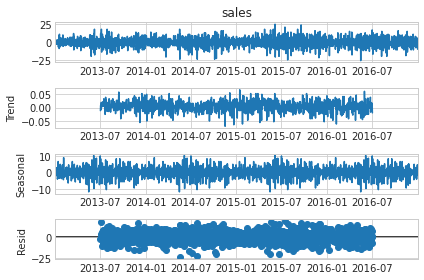

In [8]:
#decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(train.sales.diff().dropna(), model='additive', period=365)
decompose.plot()
plt.show()

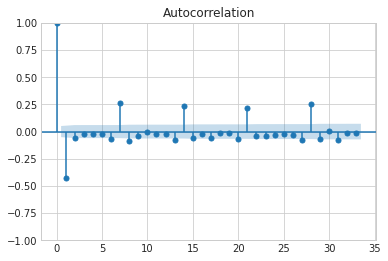

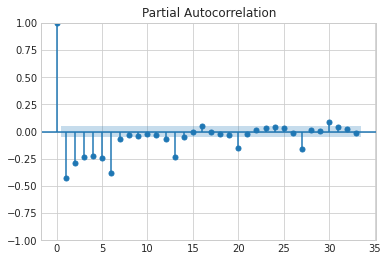

In [9]:
# plot acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train.sales.diff().dropna(),lags=33)
plt.show()
plot_pacf(train.sales.diff().dropna(),lags=33)
plt.show()

(p=?,d=1,q=6)


In [10]:
# arma_order_select_ic 
#resDiff = sm.tsa.arma_order_select_ic(train.sales, max_ar=7, max_ma=7, ic='aic', trend='c')
#print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')
# q=7 look best

In [10]:
# arima
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train.sales, order=(6,1,6),freq='D',trend='n',enforce_invertibility=False)
results_ARIMA = model.fit()
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1461
Model:                 ARIMA(6, 1, 6)   Log Likelihood               -4387.639
Date:                Fri, 12 Aug 2022   AIC                           8801.278
Time:                        06:00:37   BIC                           8869.998
Sample:                    01-01-2013   HQIC                          8826.913
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7969      0.080     -9.902      0.000      -0.955      -0.639
ar.L2         -0.5110      0.046    -11.035      0.000      -0.602      -0.420
ar.L3         -0.5000      0.049    -10.303      0.000      -0.595      -0.405
ar.L4         -0.8830      0.044    -19.863      0.000      -0.970      -0.796
ar.L5         -0.8874      0.079    -11.271      0.000      -1.042      -0.733
ar.L6         -0.1100      0.030     -3.689      0.000      -0.168      -0.052
ma.L1         -0.1326      0.077     -1.720      0.085      -0.284       0.018
ma.L2         -0.2342      0.079     -2.978      0.003      -0.388      -0.080
ma.L3          0.0520      0.068      0.769      0.442      -0.081       0.185
ma.L4          0.4505      0.068      6.604      0.000       0.317       0.584
ma.L5          0.0984      0.081      1.212      0.225      -0.061       0.257
ma.L6         -0.7181      0.070    -10.262      0.000      -0.855      -0.581
sigma2        23.6710      0.815     29.048      0.000      22.074      25.268
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                14.59
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

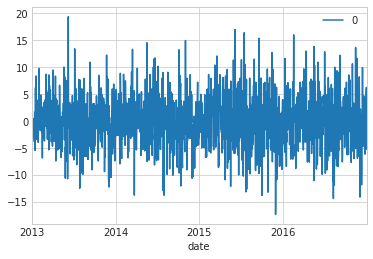

In [11]:
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot()

In [12]:
# Ljung-Box
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(residuals) 


,lb_stat,lb_pvalue
1,0.023186,0.878974
2,0.633192,0.728625
3,0.851103,0.837209
4,1.102649,0.893852
5,3.671143,0.597664
6,5.160996,0.523336
7,12.776310,0.077750
8,15.970624,0.042803
9,20.001780,0.017901
10,22.418042,0.013111


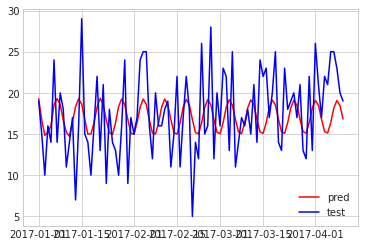

In [13]:
pred = results_ARIMA.predict('2017-01-01', '2017-12-31', dynamic=True)
plt.plot(pred[:100],label='pred',color='red')
plt.plot(test.sales[:100],label='test',color='blue')
plt.legend()
plt.show()

In [14]:
# mse
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test.sales, pred)
print('MSE:',mse)

MSE: 70.75387382389003


Arimax perform worst

In [ ]:
%%time
# seasonal order =(1,10,7,365)
model = ARIMA(train.sales, order=(6,1,6),freq='D',seasonal_order=(1,1,1,365),trend='n',enforce_invertibility=False)
results_ARIMA = model.fit()
results_ARIMA.summary()

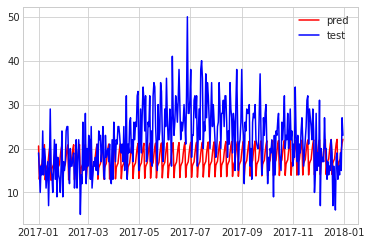

In [ ]:
pred = results_ARIMA.predict('2017-01-01', '2017-12-31', dynamic=True)
plt.plot(pred,label='pred',color='red')
plt.plot(test.sales,label='test',color='blue')
plt.legend()

In [ ]:
# mse 
mse = mean_squared_error(test.sales, pred)
print('MSE:',mse)

MSE: 58.80988468518894


In [50]:
# feature engineering
tmp['day']=tmp.index.day
tmp['month']=tmp.index.month
tmp['year']=tmp.index.year
tmp['dayofweek']=tmp.index.dayofweek


In [52]:
train = tmp[tmp.index.year<2017]
test = tmp[tmp.index.year==2017]

In [ ]:
# lgb regression
train_data = lgb.Dataset(train.drop(['sales'],axis=1),label=train.sales)
test_data = lgb.Dataset(test.drop(['sales'],axis=1),label=test.sales)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
model = lgb.train(params, train_data, num_boost_round=500, valid_sets=[train_data, test_data], early_stopping_rounds=50)
pred = model.predict(test.drop(['sales'],axis=1))
mse = mean_squared_error(test.sales, pred)
print('MSE:',mse)

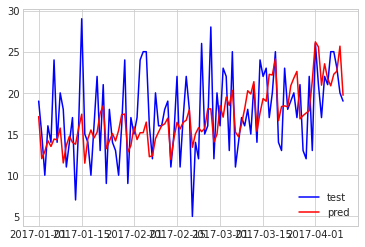

In [57]:
# plot
pred = pd.DataFrame(pred,index=test.index,columns=['sales'])
plt.plot(test.sales[:100],label='test',color='blue')
plt.plot(pred[:100],label='pred',color='red')
plt.legend()


In [42]:
train_data = pd.read_csv('data/train.csv',parse_dates=['date'],index_col='date')
test_data = pd.read_csv('data/test.csv',parse_dates=['date'],index_col='date')
train_data.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [43]:
train_data['day'] = train_data.index.day
train_data['month'] = train_data.index.month
train_data['year'] = train_data.index.year
train_data['dayofweek'] = train_data.index.dayofweek

test_data['day'] = test_data.index.day
test_data['month'] = test_data.index.month
test_data['year'] = test_data.index.year
test_data['dayofweek'] = test_data.index.dayofweek
test_data.drop(['id'],axis=1,inplace=True)

In [54]:
data = pd.concat([train_data,test_data],axis=0)
def add_lag_features(df,lags):
    for lag in lags:
        df['sales_lag_'+str(lag)] = df.groupby(['store','item'])['sales'].shift(lag)
    return df
data = add_lag_features(data,[91, 98, 105, 112, 119, 126, 182, 364, 546])

In [55]:
train_data = data[data.index.year<2018]
test_data = data[data.index.year==2018]
test_data.drop(['sales'],axis=1,inplace=True)

In [31]:
def smape(y_true, y_pred):
    denominator = (y_true + y_pred) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    return np.mean(diff) * 100.0# 

In [53]:
average_smape = 0
test_pred = np.zeros(test_data.shape[0])
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mape',
    'verbose': 0
}


   

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
smape: 58.53267476807902
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012233 seconds.
You can set `force_col_wise=true` to remove the overhead.
smape: 20.666074738385934
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
smape: 48.83457058206376
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
smape: 30.719148022947124
[LightGBM] [Warning] Auto-choosing row-wise mu

In [56]:
train = train_data[train_data.index.year<2017]
test = train_data[train_data.index.year==2017]
train_dataset = lgb.Dataset(train.drop(['sales'],axis=1),label=train.sales)
test_dataset = lgb.Dataset(test.drop(['sales'],axis=1),label=test.sales)
model = lgb.train(params, train_dataset, num_boost_round=3000, valid_sets=[train_dataset, test_dataset], early_stopping_rounds=50,verbose_eval=False)
pred = model.predict(test.drop(['sales'],axis=1))
score = smape(test.sales, pred)
print("score ",score)
test_pred = model.predict(test_data)



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
score  12.282705202407538


In [50]:
print("score ",score)


score  12.252175348090718


In [16]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission['sales'] = test_pred
sample_submission.to_csv('submission.csv')

In [20]:
train_data

,store,item,sales,day,month,year,dayofweek
date,,,,,,,
2013-01-01,1,1,13,1,1,2013,1
2013-01-02,1,1,11,2,1,2013,2
2013-01-03,1,1,14,3,1,2013,3
2013-01-04,1,1,13,4,1,2013,4
2013-01-05,1,1,10,5,1,2013,5
...,...,...,...,...,...,...,...
2017-12-27,10,50,63,27,12,2017,2
2017-12-28,10,50,59,28,12,2017,3
2017-12-29,10,50,74,29,12,2017,4


In [28]:
train_data

,store,item,sales,day,month,year
date,,,,,,
2013-01-01,1,1,13,1,1,2013
2013-01-02,1,1,11,2,1,2013
2013-01-03,1,1,14,3,1,2013
2013-01-04,1,1,13,4,1,2013
2013-01-05,1,1,10,5,1,2013
...,...,...,...,...,...,...
2017-12-27,10,50,63,27,12,2017
2017-12-28,10,50,59,28,12,2017
2017-12-29,10,50,74,29,12,2017
